# IMPORT

In [1]:
import pandas as pd
from _data_manager import DataManager
from _trade import Trade
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
%load_ext autoreload
%autoreload 2

### Option d'affichage


In [3]:
pd.set_option('display.max_columns', None)


# DATA ANALYSIS

To view the data, launch the dashboard, which offers numerous data visualizations.

In [4]:
file_path = 'EGB_historical_yield.csv'
data_manager = DataManager(file_path)


In [5]:
data_manager.data.shape

(2110, 21)

In [6]:
data_manager.data.head()

,Germany_5y,Germany_10y,Germany_30y,Belgium_5y,Belgium_10y,Belgium_30y,Austria_5y,Austria_10y,Austria_30y,Netherlands_5y,Netherlands_10y,Netherlands_30y,France_5y,France_10y,France_30y,Spain_5y,Spain_10y,Spain_30y,Italy_5y,Italy_10y,Italy_30y
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15,-16.4,53.9,131.2,-2.1,83.8,189.7,-8,77.7,160.4,-10.4,66.1,143.6,-10.4,66.1,143.6,65.4,175.0,291.2,56.1,156.4,264.9
2016-01-18,-16.6,53.6,131.2,-3.3,83.5,190.0,-8,77.4,160.7,-10.6,66.0,143.9,-10.6,66.0,143.9,64.0,174.0,291.5,56.6,156.4,266.9
2016-01-19,-16.7,54.8,132.2,-4.1,84.0,189.9,-8,78.3,161.8,-11.3,66.1,145.1,-11.3,66.1,145.1,60.5,170.1,288.2,55.3,155.7,265.2
2016-01-20,-19.8,48.1,122.5,-6.0,96.3,184.2,-11,73.2,153.1,-13.8,60.9,135.9,-13.8,60.9,135.9,65.7,178.2,296.7,62.2,164.9,275.9
2016-01-21,-24.0,44.9,121.4,-9.8,91.5,180.5,-16,69.6,153.0,-18.2,57.0,134.8,-18.2,57.0,134.8,60.2,171.9,291.5,54.4,156.1,269.5


In [7]:
data_manager.data.dtypes

Germany_5y         float64
Germany_10y        float64
Germany_30y        float64
Belgium_5y         float64
Belgium_10y        float64
Belgium_30y        float64
Austria_5y           int64
Austria_10y        float64
Austria_30y        float64
Netherlands_5y     float64
Netherlands_10y    float64
Netherlands_30y    float64
France_5y          float64
France_10y         float64
France_30y         float64
Spain_5y           float64
Spain_10y          float64
Spain_30y          float64
Italy_5y           float64
Italy_10y          float64
Italy_30y          float64
dtype: object

For the Austria 5-year rates, we only have `int64` data types, which likely indicates a lack of precision in this measurement compared to others. Given 2110 rows, the probability of having only integer numbers is virtually zero.

In [8]:
data_manager.data.isnull().sum().sort_values().head(3)

Germany_5y    0
Italy_5y      0
Spain_30y     0
dtype: int64

There are no missing data, which is good news.

In [9]:
data_manager.data.describe()

,Germany_5y,Germany_10y,Germany_30y,Belgium_5y,Belgium_10y,Belgium_30y,Austria_5y,Austria_10y,Austria_30y,Netherlands_5y,Netherlands_10y,Netherlands_30y,France_5y,France_10y,France_30y,Spain_5y,Spain_10y,Spain_30y,Italy_5y,Italy_10y,Italy_30y
count,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000
mean,11.990521,47.930995,94.990332,31.534313,88.705403,165.658104,29.082938,79.211185,135.861327,18.575592,66.287488,104.963886,18.575592,66.287488,104.963886,69.074645,145.899763,236.917393,135.596066,219.323081,301.104076
std,110.244206,97.853356,84.547229,116.515992,109.453098,96.159139,119.676026,112.184716,93.752196,116.077422,104.988257,90.751273,116.077422,104.988257,90.751273,116.066133,106.837146,97.354064,127.540894,120.103048,96.317931
min,-99.100000,-85.800000,-49.300000,-72.400000,-43.600000,26.400000,-76.000000,-48.500000,-6.600000,-86.800000,-65.200000,-38.100000,-86.800000,-65.200000,-38.100000,-45.700000,-1.900000,79.600000,-12.600000,45.500000,138.200000
25%,-58.500000,-26.275000,24.000000,-43.275000,7.200000,84.825000,-44.000000,-2.575000,56.200000,-52.800000,-12.275000,28.600000,-52.800000,-12.275000,28.600000,-13.400000,46.650000,136.625000,36.425000,121.650000,220.900000
50%,-35.400000,25.100000,90.850000,-19.650000,64.700000,160.600000,-25.000000,49.500000,132.500000,-32.200000,41.450000,99.350000,-32.200000,41.450000,99.350000,29.050000,140.150000,251.050000,78.050000,196.100000,302.650000
75%,4.050000,61.125000,127.550000,22.300000,95.750000,185.075000,14.000000,80.775000,157.800000,-2.550000,73.675000,131.000000,-2.550000,73.675000,131.000000,61.675000,169.075000,288.275000,212.850000,298.525000,361.925000
max,289.100000,296.600000,320.600000,324.400000,362.800000,418.800000,332.000000,358.400000,379.100000,313.000000,331.100000,344.600000,313.000000,331.100000,344.600000,368.300000,406.600000,469.100000,435.100000,497.900000,544.200000


In [10]:
data_manager.data.std(axis=0).sort_values()

Germany_30y         84.547229
France_30y          90.751273
Netherlands_30y     90.751273
Austria_30y         93.752196
Belgium_30y         96.159139
Italy_30y           96.317931
Spain_30y           97.354064
Germany_10y         97.853356
France_10y         104.988257
Netherlands_10y    104.988257
Spain_10y          106.837146
Belgium_10y        109.453098
Germany_5y         110.244206
Austria_10y        112.184716
Spain_5y           116.066133
France_5y          116.077422
Netherlands_5y     116.077422
Belgium_5y         116.515992
Austria_5y         119.676026
Italy_10y          120.103048
Italy_5y           127.540894
dtype: float64

Long-term bonds are generally less volatile than short-term ones, but there are some exceptions, such as the 5-year German bond (which is in the 10-year group), or Italy 10-year, which is the second most volatile bond. This indicates higher uncertainty for Italy and lower uncertainty for Germany, which is more stable. Interestingly, the order by maturity is roughly but not always consistent (such as with Spain for the 5-year rate, which is second vs. last for the 30-year rate).

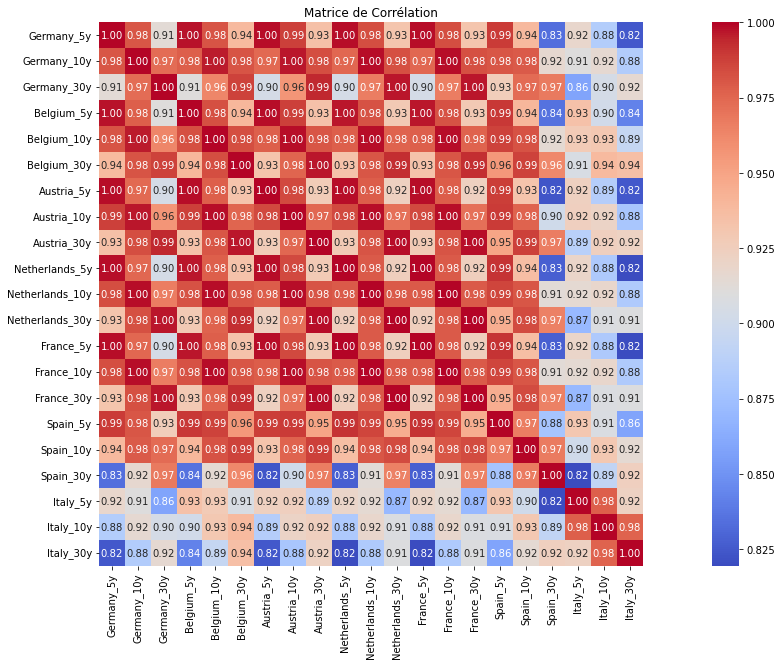

In [11]:
corr = data_manager.data.corr()

plt.figure(figsize=(25, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.2f', annot_kws={'size': 10})
plt.title('Matrice de Corrélation')
plt.show()

The set is highly correlated, with Italy appearing to be significantly less correlated than other nations with each other. It is observed that in many instances, countries with equal maturity have almost perfect correlations.

In [45]:
df.shape

(21, 2110)

### Données économiques que l'on pourrait rajouter pour aller plus loin :

- Inflation
- Chômage
- PIB (Produit Intérieur Brut)
- Indice des prix à la consommation
- Indice des prix à la production (IPP)
- Balance commerciale
- Indices boursiers
- Indicateurs de sentiment de marché
